# Plot Tracks on Map

## Libs Sections 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context('talk')
import cartopy.crs as ccrs
import cartopy.feature as cf


import glob

import tobac
import sys
import json


## Arguments

In [2]:
if 'launcher' in sys.argv[0]:
    config_file = '../scripts/config/config_precip200.json'
    date = '202006'
    interactive = True
else:
    config_file = sys.argv[1]
    date = sys.argv[2]
    interactive = False

## Configuration

In [3]:
with open(config_file, "r") as fp:
    conf = json.load(fp)
globals().update(conf)

## Input Data 

In [4]:
main_dir = "/work/bb1376/user/fabian/data/oxford-hackathon"
subname = f"{vname}_tracks_thresh{threshold}"

input_dir = f"/{main_dir}/{model}/{experiment}/tracks"
infile = f'{input_dir}/monthly_{subname}_{date}.nc'

tracks = xr.open_dataset( infile, ) #chunks = 'auto' )

tracks = tracks.isel(index = slice(0,2000000)).load()

tracks = tracks.dropna('index')

tracks['ones'] = xr.ones_like(tracks['total'])
del tracks['timestr']

/tmp/ipykernel_132270/1930982451.py:7: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  tracks = xr.open_dataset( infile, ) #chunks = 'auto' )


## Preparing Selection of Track Properties

In [5]:
tracks

<xarray.Dataset> Size: 302MB
Dimensions:          (index: 1884835)
Coordinates:
  * index            (index) int64 15MB 3 4 6 7 ... 1999996 1999997 1999999
Data variables: (12/25)
    frame            (index) int64 15MB 0 0 0 0 0 0 ... 321 321 321 321 321 321
    idx              (index) int64 15MB 4 5 7 8 10 ... 4378 4379 4380 4381 4383
    hdim_1           (index) float64 15MB 618.0 619.0 ... 2.098e+03 2.098e+03
    hdim_2           (index) float64 15MB 2.758e+03 5.384e+03 ... 5.227e+03
    num              (index) int64 15MB 1 3 2 2 6 20 10 23 ... 13 10 9 7 15 3 3
    threshold_value  (index) int64 15MB 200 200 200 200 200 ... 200 200 200 200
    ...               ...
    latitude         (index) float64 15MB -59.07 -59.02 -58.36 ... 14.93 14.94
    longitude        (index) float64 15MB 137.9 269.2 139.0 ... 181.9 261.3
    area             (index) float64 15MB 1.587e+07 6.356e+07 ... 8.949e+07
    cell             (index) int64 15MB 4 5 7 8 ... 297654 300489 304441 307472
    time_cell        (index) timedelta64[ns] 15MB 00:00:00 00:00:00 ... 00:00:00
    ones             (index) float32 8MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [6]:
tg = tracks.groupby('cell')

In [7]:
track_mean = tg.mean()
track_sum = tg.sum()
track_max = tg.max()

In [8]:
summed_total95_threshold = np.percentile( track_sum['total'], 99 )
max_area95_threshold = np.percentile( track_max['area'].dropna('cell'), 99 )
lifetime95_threshold = np.percentile( track_sum['ones'], 99 )

In [9]:
summed_total95_threshold, max_area95_threshold, lifetime95_threshold

(np.float32(314423.94), np.float64(1940961267.2247536), np.float32(28.0))

In [10]:
total95_cellindex = track_sum.cell[track_sum.total >= summed_total95_threshold]

area95_cellindex = track_max.cell[track_max.area >= max_area95_threshold]

lifetime95_cellindex = track_sum.cell[track_sum.ones >= lifetime95_threshold]


## Filtering

In [11]:
def filter_features_with_cell_index(features, cell_index ): 
    dfilter = cell_index
    d = features

    # Extract the unique cell values from dfilter
    filter_cells = set(dfilter.cell.values)
    
    # Create a boolean mask for rows in the original dataset
    mask = np.isin(d.cell, list(filter_cells))
    
    selindex = d.index[mask]
    
    # Apply the mask to filter the original dataset
    d_filtered = d.sel(index = selindex)

    return d_filtered

In [12]:
tracks_area_filtered = filter_features_with_cell_index( tracks, area95_cellindex )
tracks_totals_filtered = filter_features_with_cell_index( tracks, total95_cellindex )
tracks_lifetime_filtered = filter_features_with_cell_index( tracks, lifetime95_cellindex )



## Plotting

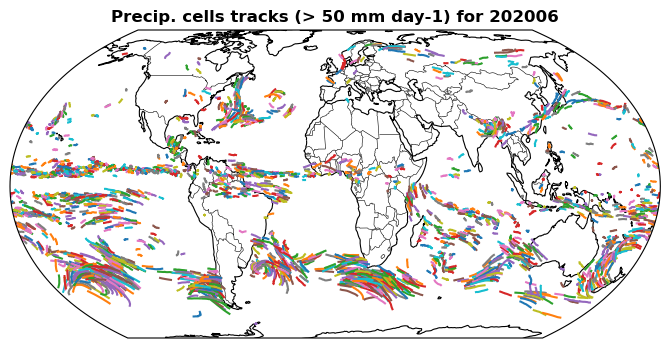

In [13]:
if interactive:
    target_map = ccrs.EqualEarth()
    fig, axs = plt.subplots(ncols=1, nrows = 1, subplot_kw={'projection': target_map}, figsize = (24,4))
    plt.sca( axs ) #[0] )

    for cell_label, cell in tracks_lifetime_filtered.groupby('cell'):
        axs.plot( cell.longitude, cell.latitude, '-', transform=ccrs.PlateCarree())
    
    ax = plt.gca()
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    ax.set_title(f'Precip. cells tracks (> 50 mm day-1) for {date}', fontweight = 'bold') 